# Scaling Sensitivity Analysis with Emulation

## Context
In the field of cardiovascular modeling, capturing the dynamics of blood flow and the associated pressures and volumes within the vascular system is crucial for understanding heart function and disease. Physics-based models that accurately represent these dynamics often require significant computational resources, making them challenging to apply in large-scale or real-time scenarios. Emulation techniques provide a way to achieve high-fidelity simulations of the cardiovascular system, allowing for efficient and accurate analysis of key hemodynamic parameters.

## Purpose
In this tutorial, we will demonstrate the application of `AutoEmulate` within a cardiac modeling pipeline, specifically focusing on the reconstruction of critical heart parameters using synthetic data. The goal is to demonstrate how these measures—such as arterial systemic pressure, and flow rates —can be leveraged to estimate a range of model parameters related to cardiac mechanics and cardiovascular hemodynamics. 

By the end of this tutorial, participants will have a clear understanding of how to use emulation to facilitate the real-time simulation of complex cardiac dynamics on a local CPU.

Participants will learn how to explore the relationship between underlying cardiac health parameters and non-invasive measures using synthetic data, with a focus on how these insights can improve understanding and estimation of key cardiovascular dynamics.

## Description
The tutorial will cover setting up simulations, applying emulation techniques, assessing model accuracy, performing sensitivity analysis, and comparing computational resources for different modeling approaches. 

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm

from autoemulate.compare import AutoEmulate

from SALib.sample import sobol as sobol_sampler
from SALib.analyze import sobol as sobol_analyzer

from sklearn.metrics import r2_score

#TODO: define simulator directly in notebook or add to autoemulate simulation options
from flow_functions import FlowProblem

from autoemulate.experimental_design import LatinHypercube


ModuleNotFoundError: No module named 'flow_functions'

### Define your simulator

<!-- #TODO: add brief description about this simulator -->

In [ ]:
fp = FlowProblem(ncycles=10, ncomp=10, amp=900.)
fp.generate_pulse_function()
fp.solve()

In [ ]:
# add explanation what we are outputting here
fp.res.t

array([ 9.00046485,  9.00146485,  9.00246485, ...,  9.99846485,
        9.99946485, 10.        ])

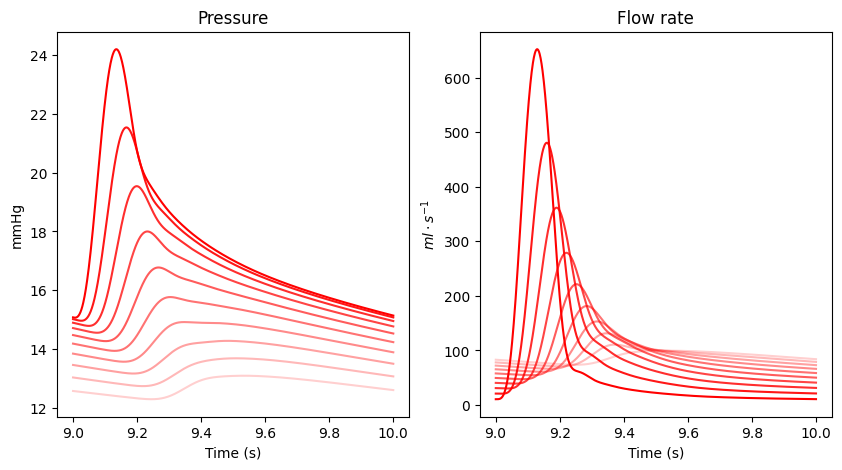

In [ ]:
fig, ax = fp.plot_res()
plt.show()

In [ ]:
## specify valid parameter ranges
# Dictionary with parameters and their scaled ranges for the blood flow model
parameters_range = {
    'T': tuple(np.array([0.5, 1.5]) * 1.0),  # Cardiac cycle period (s)
    'td': tuple(np.array([0.8, 1.2]) * 0.2),  # Pulse duration (s)
    'amp': tuple(np.array([0.8, 1.2]) * 900.0),  # Amplitude (e.g., pressure or flow rate)
    'dt': tuple(np.array([0.5, 1.5]) * 0.001),  # Time step (s)
    'C': tuple(np.array([0.8, 1.2]) * 38.0),  # Compliance (unit varies based on context)
    'R': tuple(np.array([0.8, 1.2]) * 0.06),  # Resistance (unit varies based on context)
    'L': tuple(np.array([0.8, 1.2]) * 0.0017),  # Inductance (unit varies based on context)
    'R_o': tuple(np.array([0.8, 1.2]) * 0.025),  # Outflow resistance (unit varies based on context)
    'p_o': tuple(np.array([0.9, 1.1]) * 10.0)  # Initial pressure (unit varies based on context)
}

# Output the dictionary for verification
parameters_range

{'T': (0.5, 1.5),
 'td': (0.16000000000000003, 0.24),
 'amp': (720.0, 1080.0),
 'dt': (0.0005, 0.0015),
 'C': (30.400000000000002, 45.6),
 'R': (0.048, 0.072),
 'L': (0.00136, 0.0020399999999999997),
 'R_o': (0.020000000000000004, 0.03),
 'p_o': (9.0, 11.0)}

### Experimental Design

In [ ]:
## sample from parameter range
N_samples = 60
lhd = LatinHypercube(parameters_range.values())
sample_array = lhd.sample(N_samples)
sample_df    = pd.DataFrame(sample_array, columns=parameters_range.keys())  

In [ ]:
# enforce parameter relations (eg td <= T)
sample_df['td'] = sample_df.apply(lambda row: row['td']* row['T'], axis=1)


### Simulate

In [ ]:

# Fixed parameters: Number of compartments and cycles
ncomp = 10
ncycles = 10

# Function to run a simulation for a given set of parameters
def simulate(param_dict):
    fp = FlowProblem(ncycles=ncycles, ncomp=ncomp, **param_dict)
    fp.generate_pulse_function()
    fp.solve()
    return fp, fp.res.t, fp.res.y

Y = []
# Iterate over each sample of parameters
for index, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    param_dict = row.to_dict() 
    fp, t, y = simulate(param_dict) 
    
    # extract peak pressure
    peak_pressure = y[:ncomp, :].max()
      
    Y.append(peak_pressure)

100%|██████████| 60/60 [01:09<00:00,  1.16s/it]


### Emulate & Validate

In [ ]:
em = AutoEmulate()
parameter_names = list(parameters_range.keys())
em.setup(sample_df[parameter_names], Y)
best_model = em.compare()

,Values
Simulation input shape (X),"(60, 9)"
Simulation output shape (y),"(60,)"
# hold-out set samples (test_set_size),12
Do hyperparameter search (param_search),False
Type of hyperparameter search (search_type),random
# sampled parameter settings (param_search_iters),20
Scale data before fitting (scale),True
Scaler (scaler),StandardScaler
Dimensionality reduction before fitting (reduce_dim),False
Dimensionality reduction method (dim_reducer),PCA


Initializing:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
em.print_results()

,model,short,r2,rmse
0,RadialBasisFunctions,rbf,0.9822,11.5883
1,GaussianProcess,gp,0.9761,12.7644
2,GradientBoosting,gb,0.8091,34.4051
3,SecondOrderPolynomial,sop,0.7984,34.1847
4,RandomForest,rf,0.7283,40.6937
5,SupportVectorMachines,svm,0.7060,42.9996
6,LightGBM,lgbm,-0.2432,90.4790
7,NeuralNetSk,nns,-9.0344,232.3841
8,PyTorchMultiLayerPerceptron,ptmlp,-62.3488,646.6179
9,PyTorchRadialBasisFunctionsNetwork,ptrbfn,-75.6446,648.1110


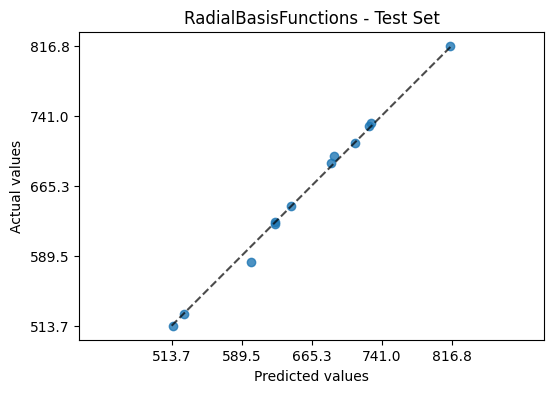

In [ ]:
em.plot_model(model=best_model)

In [ ]:
em.evaluate_model(best_model)  
best_emulator = em.refit_model(best_model)

### Sensitivity Analysis

In [ ]:
# Extract parameter names and bounds from the dictionary
parameter_names = list(parameters_range.keys())
parameter_bounds = list(parameters_range.values())

# Define the problem dictionary for Sobol sensitivity analysis
problem = {
    'num_vars': len(parameter_names),
    'names': parameter_names,
    'bounds': parameter_bounds
}
sa_values = sobol_sampler.sample(problem=problem, 
                                     N=1000, #'Number of values sampled for the Sobol sensitivity analysis
                                     calc_second_order=True
                                     )
print('sa_values shape\n', sa_values.shape)
em_predict = best_emulator.predict(sa_values)
print('em_values shape\n', em_predict.shape)

sa_values shape
 (20000, 9)
em_values shape
 (20000,)


In [ ]:
# Perform Sobol sensitivity analysis
sensitivity_results = sobol_analyzer.analyze(
    problem=problem,
    Y=em_predict,
    calc_second_order=True,
    print_to_console=True
)

           ST   ST_conf
T    0.000939  0.000118
td   0.021005  0.001980
amp  0.881977  0.059741
dt   0.000456  0.000073
C    0.036187  0.003439
R    0.055199  0.004973
L    0.004361  0.000428
R_o  0.000384  0.000066
p_o  0.000308  0.000043
           S1   S1_conf
T    0.001222  0.002528
td   0.020941  0.012190
amp  0.881362  0.070971
dt   0.000260  0.002047
C    0.034949  0.018189
R    0.055900  0.020388
L    0.003679  0.005370
R_o  0.000512  0.001538
p_o -0.000673  0.001459
                  S2   S2_conf
(T, td)    -0.000243  0.003540
(T, amp)   -0.000978  0.004154
(T, dt)    -0.000398  0.003495
(T, C)     -0.000175  0.003607
(T, R)     -0.000456  0.003405
(T, L)     -0.000546  0.003519
(T, R_o)   -0.000372  0.003505
(T, p_o)   -0.000432  0.003496
(td, amp)  -0.000500  0.024086
(td, dt)   -0.000255  0.018314
(td, C)     0.000162  0.018048
(td, R)    -0.000451  0.018304
(td, L)    -0.000396  0.018410
(td, R_o)   0.000016  0.018310
(td, p_o)  -0.000286  0.018330
(amp, dt)   0.001416  0.

In [ ]:

# Extracting first-order, second-order, and total-order sensitivity indices
print(sensitivity_results['S1'])  # First-order sensitivity indices
print(sensitivity_results['ST']) # Total-order sensitivity indices
print(sensitivity_results['S2'])  # Second-order sensitivity indices matrix


[ 1.22224709e-03  2.09411944e-02  8.81362275e-01  2.60232743e-04
  3.49490127e-02  5.59004496e-02  3.67944691e-03  5.12022774e-04
 -6.72951751e-04]
[9.38888107e-04 2.10051378e-02 8.81977348e-01 4.56498668e-04
 3.61867896e-02 5.51993303e-02 4.36120664e-03 3.83712206e-04
 3.07731661e-04]
[[            nan -2.42699038e-04 -9.78247760e-04 -3.98400718e-04
  -1.75074232e-04 -4.56124519e-04 -5.45780266e-04 -3.72472076e-04
  -4.32307314e-04]
 [            nan             nan -5.00204584e-04 -2.54756418e-04
   1.61780344e-04 -4.51231597e-04 -3.95505552e-04  1.56869020e-05
  -2.85708186e-04]
 [            nan             nan             nan  1.41587448e-03
   6.31507676e-04 -1.06010660e-04  2.35555155e-03  1.39840677e-04
   1.35046552e-03]
 [            nan             nan             nan             nan
   2.70673951e-04  2.61548299e-04  1.07687876e-04  2.18614253e-04
   1.87927539e-04]
 [            nan             nan             nan             nan
              nan  1.31992861e-03  2.603779

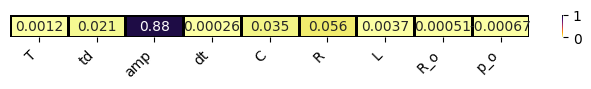

In [ ]:
Si = sensitivity_results['S1']
parameter_names = problem['names'] 

# Si should be a 2D array for seaborn's heatmap, so we reshape it accordingly
Si_reshaped = Si.reshape(1, -1)  # 1 row, len(Si) columns

# plot parameter heatmap (makes more sense for multiple components)
fig, ax = plt.subplots(figsize=(0.2 * len(Si) + 5, 1))  # Adjust the size as needed
cmap = plt.get_cmap('inferno').reversed()
sb.heatmap(Si_reshaped, vmin=0.0, vmax=1.0, ax=ax, linecolor='k', linewidths=2, cmap=cmap, annot=True)

ax.set_xticks(np.arange(len(parameter_names)) + 0.5)
ax.set_xticklabels(parameter_names, rotation=45, ha='right')
ax.set_yticks([])  # No need for y-axis labels since we only have one row

# Tight layout for better fit
fig.tight_layout()

# Show the plot
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

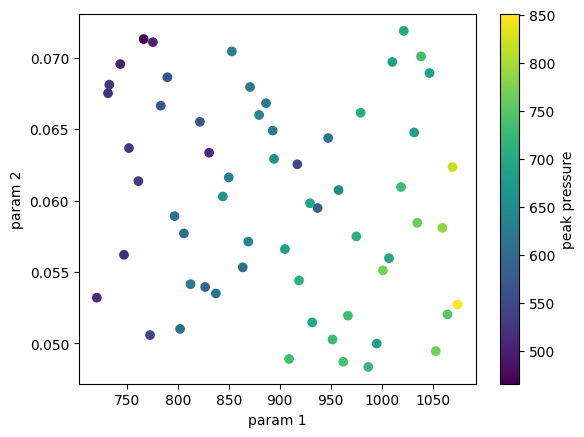

In [ ]:
#visualize most relevant parameters
param_1 = sample_df['amp']
param_2 = sample_df['R']

plt.scatter(param_1, param_2, c=Y, cmap='viridis')
plt.xlabel('param 1')
plt.ylabel('param 2')
plt.colorbar(label="peak pressure")
plt.show